In [1]:
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

from gensim import corpora, models, similarities, matutils
import pyLDAvis.gensim

from sklearn.manifold import TSNE

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Populating the interactive namespace from numpy and matplotlib


In [61]:
preprocessed = pd.read_pickle('pkl/mvp_preprocessed.pkl')

links = pd.read_pickle('pkl/mvp_links.pkl')

In [11]:
# words = corpora.Dictionary(preprocessed)
# words.filter_extremes(no_below=2, no_above=.9)
# words.compactify()

# corpus = [words.doc2bow(text) for text in preprocessed]

# print(words)

2018-03-04 18:43:44,645 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-03-04 18:43:44,863 : INFO : built Dictionary(14132 unique tokens: ['able', 'absolute', 'absolutely', 'abundance', 'abuse']...) from 48 documents (total 161332 corpus positions)
2018-03-04 18:43:44,891 : INFO : discarding 9410 tokens: [('absolutely', 46), ('acrylic', 1), ('aikoso', 1), ('airis', 1), ('amazing', 47), ('amazingstill', 1), ('analyzing', 1), ('anxiety', 48), ('anxietyat', 1), ('anxietyblue', 1)]...
2018-03-04 18:43:44,892 : INFO : keeping 4722 tokens which were in no less than 2 and no more than 43 (=90.0%) documents
2018-03-04 18:43:44,909 : INFO : resulting dictionary: Dictionary(4722 unique tokens: ['able', 'absolute', 'abundance', 'abuse', 'accept']...)


Dictionary(4722 unique tokens: ['able', 'absolute', 'abundance', 'abuse', 'accept']...)


# strain name filter

In [62]:
# after some EDA, the names of strains are showing up way too frequently
# we need to parse these out

names = []
for name in links:
    name = name.split('/')[2]
    name = name.split('-')
    for n in name:
        names.append(n)
names[:10]

['blue',
 'dream',
 'sour',
 'diesel',
 'gsc',
 'green',
 'crack',
 'og',
 'kush',
 'granddaddy']

In [63]:
name_filtered = []
for strain in preprocessed:
    strain_filter = [word for word in strain if word not in names]
    name_filtered.append(strain_filter)

In [70]:
# building a dictionary, and clearing outliers

words = corpora.Dictionary(name_filtered)
words.filter_extremes(no_below=20, no_above=.8)
words.compactify()

corpus = [words.doc2bow(text) for text in name_filtered]

print(words)

2018-03-04 23:02:12,060 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-03-04 23:02:12,207 : INFO : built Dictionary(14069 unique tokens: ['able', 'absolute', 'absolutely', 'abundance', 'abuse']...) from 48 documents (total 154890 corpus positions)
2018-03-04 23:02:12,235 : INFO : discarding 13615 tokens: [('able', 43), ('absolutely', 46), ('abundance', 5), ('abuse', 2), ('accept', 2), ('accomplish', 12), ('accurate', 5), ('accurately', 3), ('acrylic', 1), ('act', 15)]...
2018-03-04 23:02:12,236 : INFO : keeping 454 tokens which were in no less than 20 and no more than 38 (=80.0%) documents
2018-03-04 23:02:12,246 : INFO : resulting dictionary: Dictionary(454 unique tokens: ['absolute', 'ache', 'active', 'activity', 'add']...)


Dictionary(454 unique tokens: ['absolute', 'ache', 'active', 'activity', 'add']...)


# TF-IDF

In [37]:
tfidf = models.TfidfModel(corpus)

2018-03-04 21:05:13,995 : INFO : collecting document frequencies
2018-03-04 21:05:13,997 : INFO : PROGRESS: processing document #0
2018-03-04 21:05:14,009 : INFO : calculating IDF weights for 48 documents and 2103 features (30453 matrix non-zeros)


In [38]:
corpus_tfidf = tfidf[corpus]

# LDA

In [ ]:
lda = models.LdaModel(corpus=corpus, num_topics=3, id2word=words, passes=100, chunksize=48, random_state=42)

2018-03-04 23:07:28,497 : INFO : using symmetric alpha at 0.3333333333333333
2018-03-04 23:07:28,500 : INFO : using symmetric eta at 0.3333333333333333
2018-03-04 23:07:28,502 : INFO : using serial LDA version on this node
2018-03-04 23:07:28,528 : INFO : running online (multi-pass) LDA training, 3 topics, 100 passes over the supplied corpus of 48 documents, updating model once every 48 documents, evaluating perplexity every 48 documents, iterating 50x with a convergence threshold of 0.001000
2018-03-04 23:07:29,753 : INFO : -6.564 per-word bound, 94.6 perplexity estimate based on a held-out corpus of 48 documents with 29900 words
2018-03-04 23:07:29,754 : INFO : PROGRESS: pass 0, at document #48/48
2018-03-04 23:07:30,039 : INFO : topic #0 (0.333): 0.006*"insomnia" + 0.005*"sticky" + 0.005*"sativas" + 0.005*"pleasant" + 0.005*"girl" + 0.005*"ptsd" + 0.004*"dark" + 0.004*"movie" + 0.004*"melt" + 0.004*"cbd"
2018-03-04 23:07:30,041 : INFO : topic #1 (0.333): 0.008*"cbd" + 0.006*"god" + 

In [ ]:
lda.print_topics()

In [75]:
lda_corpus = lda[corpus]

lda_docs = [doc for doc in lda_corpus]

In [76]:
lda_docs[0]

[(0, 0.2589649), (1, 0.16004159), (2, 0.39278847), (4, 0.18779835)]

In [77]:
lda_docs[2]

[(0, 0.76108736), (1, 0.013429657), (2, 0.1771009), (4, 0.04793178)]

In [78]:
# with 3 /tmp/lda
# with 8 /tmp/lda2
# with 4 /tmp/lda3
# with 2 /tmp/lda4

lda.save('/tmp/lda4.model')

2018-03-04 19:56:58,087 : INFO : saving LdaState object under /tmp/lda4.model.state, separately None
2018-03-04 19:56:58,091 : INFO : saved /tmp/lda4.model.state
2018-03-04 19:56:58,097 : INFO : saving LdaModel object under /tmp/lda4.model, separately ['expElogbeta', 'sstats']
2018-03-04 19:56:58,098 : INFO : storing np array 'expElogbeta' to /tmp/lda4.model.expElogbeta.npy
2018-03-04 19:56:58,100 : INFO : not storing attribute id2word
2018-03-04 19:56:58,100 : INFO : not storing attribute dispatcher
2018-03-04 19:56:58,101 : INFO : not storing attribute state
2018-03-04 19:56:58,103 : INFO : saved /tmp/lda4.model


# pyLDAvis

In [78]:
weed_vis_data = pyLDAvis.gensim.prepare(lda, corpus, words)

/home/nate/anaconda/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


In [79]:
pyLDAvis.show(weed_vis_data)


Note: if you're in the IPython notebook, pyLDAvis.show() is not the best command
      to use. Consider using pyLDAvis.display(), or pyLDAvis.enable_notebook().
      See more information at http://pyLDAvis.github.io/quickstart.html .

You must interrupt the kernel to end this command

Serving to http://127.0.0.1:8889/    [Ctrl-C to exit]


127.0.0.1 - - [04/Mar/2018 23:06:54] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [04/Mar/2018 23:06:54] "GET /LDAvis.css HTTP/1.1" 200 -
127.0.0.1 - - [04/Mar/2018 23:06:54] "GET /d3.js HTTP/1.1" 200 -
127.0.0.1 - - [04/Mar/2018 23:06:54] "GET /LDAvis.js HTTP/1.1" 200 -



stopping Server...


# word2vec

In [12]:
w2v = models.Word2Vec(preprocessed, size=100, window=5, min_count=10, sg=1)

2018-03-04 20:41:12,929 : INFO : collecting all words and their counts
2018-03-04 20:41:12,935 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-03-04 20:41:13,002 : INFO : collected 14132 word types from a corpus of 161332 raw words and 48 sentences
2018-03-04 20:41:13,008 : INFO : Loading a fresh vocabulary
2018-03-04 20:41:13,036 : INFO : min_count=10 retains 1829 unique words (12% of original 14132, drops 12303)
2018-03-04 20:41:13,041 : INFO : min_count=10 leaves 137219 word corpus (85% of original 161332, drops 24113)
2018-03-04 20:41:13,068 : INFO : deleting the raw counts dictionary of 14132 items
2018-03-04 20:41:13,076 : INFO : sample=0.001 downsamples 62 most-common words
2018-03-04 20:41:13,082 : INFO : downsampling leaves estimated 114284 word corpus (83.3% of prior 137219)
2018-03-04 20:41:13,102 : INFO : estimated required memory for 1829 words and 100 dimensions: 2377700 bytes
2018-03-04 20:41:13,107 : INFO : resetting layer weights
2018-03

In [35]:
creative = w2v.most_similar('creative', topn=50)
insomnia = w2v.most_similar('insomnia', topn=50)

/home/nate/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/home/nate/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


In [36]:
insomnia

[('relieve', 0.9362282752990723),
 ('treat', 0.9004640579223633),
 ('syndrome', 0.8981406092643738),
 ('help', 0.8938719034194946),
 ('spasm', 0.891391396522522),
 ('reliever', 0.8872268199920654),
 ('seek', 0.8759393692016602),
 ('management', 0.8742090463638306),
 ('adhd', 0.8704590797424316),
 ('lack', 0.8642382621765137),
 ('issue', 0.8624235391616821),
 ('combat', 0.8609673380851746),
 ('aid', 0.8604822158813477),
 ('fatigue', 0.8578372001647949),
 ('relief', 0.8576319217681885),
 ('appetite', 0.857280969619751),
 ('suffer', 0.8535553812980652),
 ('ocd', 0.852756142616272),
 ('bipolar', 0.8518076539039612),
 ('inflammation', 0.8477839231491089),
 ('associate', 0.8474406003952026),
 ('nausea', 0.8474018573760986),
 ('stimulation', 0.8455299735069275),
 ('asthma', 0.8423830270767212),
 ('muscle', 0.8417842388153076),
 ('severe', 0.8413331508636475),
 ('effective', 0.8378428220748901),
 ('reduce', 0.8378371000289917),
 ('nighttime', 0.8366255760192871),
 ('plus', 0.8337677717208862),

In [26]:
type1_neighbors = ['creative']
type2_neighbors = ['insomnia']

for i in range(50):
    type1_neighbors.append(creative[i][0])
    type2_neighbors.append(insomnia[i][0])

# t-SNE

In [21]:
vocab = list(w2v.wv.vocab)
X = w2v[vocab]
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

/home/nate/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [22]:
df = pd.DataFrame(X_tsne, index=vocab, columns=['x', 'y'])
df.head(10)

,x,y
friend,-4.389232,-9.055402
stoner,28.233547,8.837675
lend,-10.358463,27.301403
ear,-19.019289,-30.972103
bring,-21.039579,-9.618845
blue,23.523329,39.132969
dream,23.516602,39.126423
calm,-27.326448,-32.290371
night,-4.214025,-31.608730
purchase,23.634438,29.319057


In [110]:
# energy_group = re.findall('\"(.*?)\"', lda.print_topics()[0][1])
# sleepy_group = re.findall('\"(.*?)\"', lda.print_topics()[1][1])

In [28]:
plot_creative = []
plot_insomnia = []
plot_else = []

for word, pos in df.iterrows():
    if word in type1_neighbors:
        plot_creative.append([word, pos])
    elif word in type2_neighbors:
        plot_insomnia.append([word, pos])
    else:
        plot_else.append([word, pos])

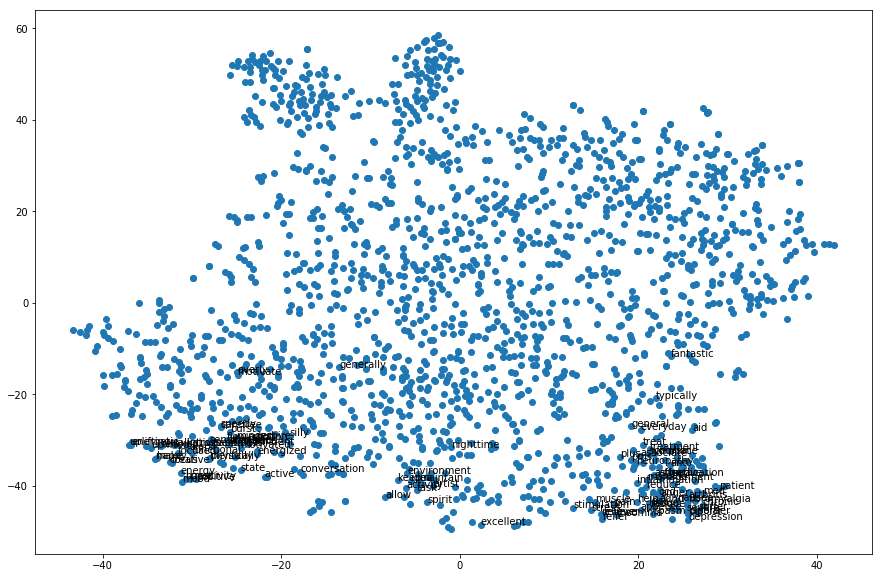

In [30]:
plt.figure(figsize=(15,10))

plt.scatter(df['x'], df['y'])

for word, pos in df.iterrows():
    if word in type1_neighbors:
        plt.annotate(word, pos)
    elif word in type2_neighbors:
        plt.annotate(word, pos)